<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04_modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [1]:
%pip install statstests

In [2]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
from statstests.tests import overdisp
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson


In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Mounted at /content/drive


In [4]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [5]:
df.head()

,date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,...,category_arts_entertainment_recreation,category_travel_hospitality,category_professional_business_services,category_health_medical,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,2010-01-01 00:00:00,6,0,15.875000,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01 00:15:00,4,0,22.262500,22.245049,0.012927,-1.980469,49.500000,16.663333,-0.134765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-01 00:30:00,10,0,34.644000,45.188942,-0.779579,0.460440,48.600000,4.993329,-0.461034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.500000,18.251027,0.262932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.483960,54.500000,9.648834,0.573632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344191 entries, 0 to 344190
Data columns (total 61 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   date_window                              344191 non-null  datetime64[us]
 1   transactions                             344191 non-null  uint32        
 2   frauds                                   344191 non-null  int32         
 3   mean_amount                              344191 non-null  float64       
 4   std_amount                               342118 non-null  float64       
 5   skew_amount                              342116 non-null  float64       
 6   kurtosis_amount                          342116 non-null  float64       
 7   mean_current_age                         344191 non-null  float64       
 8   std_current_age                          342118 non-null  float64       
 9   skew_current_age          

In [7]:
df.describe()

,date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,...,category_arts_entertainment_recreation,category_travel_hospitality,category_professional_business_services,category_health_medical,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
count,344191,344191.000000,344191.000000,344191.000000,342118.000000,342116.000000,342116.000000,344191.000000,342118.000000,341971.000000,...,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000,344191.000000
mean,2014-12-01 22:29:15.840797,25.901209,0.038734,46.689266,71.645585,0.846947,3.798932,53.815317,15.191513,0.429373,...,0.019333,0.005556,0.008239,0.065248,0.008009,0.004446,0.000420,0.028306,0.012966,0.008028
min,2010-01-01 00:00:00,1.000000,0.000000,-488.000000,0.000000,-5.390673,-2.000000,23.500000,0.000000,-1.980365,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-17 14:22:30,9.000000,0.000000,32.612523,44.095898,0.000000,0.060794,51.423077,13.641248,0.201530,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014-12-01 23:15:00,25.000000,0.000000,42.730227,57.067318,0.750348,1.637112,53.833333,15.423287,0.454744,...,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017-05-17 22:07:30,40.000000,0.000000,55.543170,83.405991,1.630688,5.125906,56.187500,17.018589,0.689205,...,0.020000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000
max,2019-10-31 23:45:00,75.000000,5.000000,2014.420000,2347.052609,7.488300,55.037830,99.000000,51.618795,2.661910,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,16.207450,0.230214,28.805452,49.447956,1.569915,6.264675,4.628763,3.397723,0.425949,...,0.042678,0.028832,0.034438,0.074635,0.028369,0.020702,0.006123,0.053458,0.041687,0.019616


In [8]:
df['frauds'].value_counts(normalize=True)

,proportion
frauds,
0,0.968024
1,0.026183
2,0.004977
3,0.000680
4,0.000125
5,0.000012


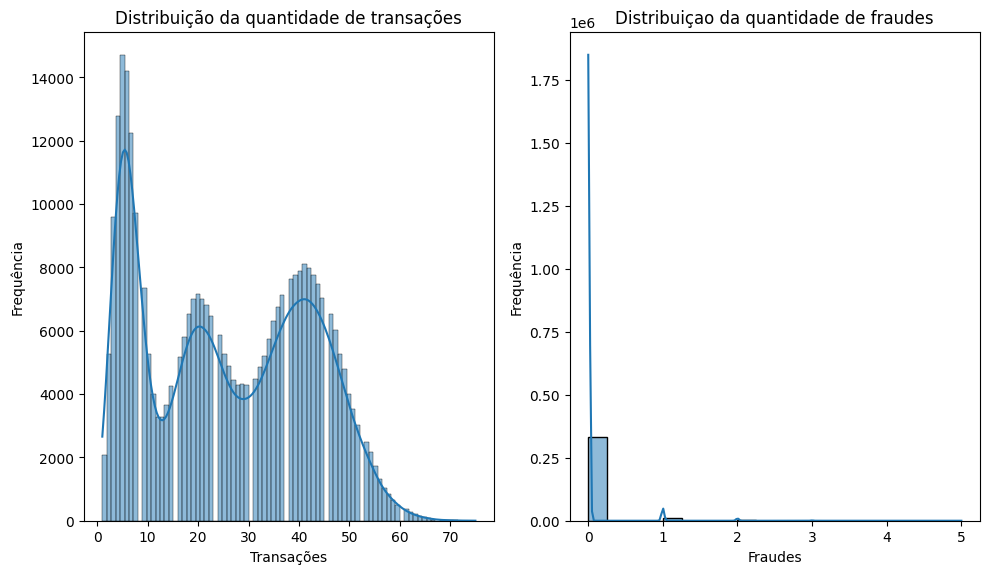

In [9]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.title('Distribuição da quantidade de transações')
sns.histplot(df['transactions'], kde=True)
plt.xlabel('Transações')
plt.ylabel('Frequência')

plt.subplot(122)
plt.title('Distribuiçao da quantidade de fraudes')
sns.histplot(df['frauds'], kde=True)
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, 6, 1))

plt.tight_layout()
plt.show()

## Implementação de Modelos

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos
O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$


In [18]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.038734,0.052999


In [11]:
modelo_poison_simple = smf.glm(formula='frauds ~ transactions', data=df, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:               344191
Model:                            GLM   Df Residuals:                   344189
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53299.
Date:                Sat, 24 May 2025   Deviance:                       83242.
Time:                        17:25:17   Pearson chi2:                 4.08e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02942
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.2258      0.027   -192.547      0.000      -5.279      -5.173
transactions     0.0593      0.001     91.760      0.000       0.058       0.061
================================================================================
"""

In [12]:
all_features = df.drop(columns=['frauds', 'date_window']).columns.to_list()
all_features

['transactions',
 'mean_amount',
 'std_amount',
 'skew_amount',
 'kurtosis_amount',
 'mean_current_age',
 'std_current_age',
 'skew_current_age',
 'kurtosis_current_age',
 'mean_per_capita_income',
 'std_per_capita_income',
 'skew_per_capita_income',
 'kurtosis_per_capita_income',
 'mean_total_debt',
 'std_total_debt',
 'skew_total_debt',
 'kurtosis_total_debt',
 'mean_credit_score',
 'std_credit_score',
 'skew_credit_score',
 'kurtosis_credit_score',
 'mean_num_credit_cards',
 'std_num_credit_cards',
 'skew_num_credit_cards',
 'kurtosis_num_credit_cards',
 'mean_credit_limit',
 'std_credit_limit',
 'skew_credit_limit',
 'kurtosis_credit_limit',
 'use_chip_online_transaction',
 'use_chip_swipe_transaction',
 'use_chip_chip_transaction',
 'gender_female',
 'card_brand_visa',
 'card_brand_mastercard',
 'card_brand_amex',
 'card_brand_discover',
 'card_type_debit',
 'card_type_credit',
 'card_type_debit_prepaid',
 'has_chip_no',
 'online_sales_no',
 'category_transportation_logistics',
 '

In [13]:
poison_complete_formula = 'frauds ~ ' + ' + '.join(all_features)
poison_complete_formula

'frauds ~ transactions + mean_amount + std_amount + skew_amount + kurtosis_amount + mean_current_age + std_current_age + skew_current_age + kurtosis_current_age + mean_per_capita_income + std_per_capita_income + skew_per_capita_income + kurtosis_per_capita_income + mean_total_debt + std_total_debt + skew_total_debt + kurtosis_total_debt + mean_credit_score + std_credit_score + skew_credit_score + kurtosis_credit_score + mean_num_credit_cards + std_num_credit_cards + skew_num_credit_cards + kurtosis_num_credit_cards + mean_credit_limit + std_credit_limit + skew_credit_limit + kurtosis_credit_limit + use_chip_online_transaction + use_chip_swipe_transaction + use_chip_chip_transaction + gender_female + card_brand_visa + card_brand_mastercard + card_brand_amex + card_brand_discover + card_type_debit + card_type_credit + card_type_debit_prepaid + has_chip_no + online_sales_no + category_transportation_logistics + category_financial_insurance + category_food_beverage + category_retail_genera

In [14]:
modelo_poison_complete = smf.glm(formula=poison_complete_formula, data=df, family=sm.families.Poisson()).fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:               340559
Model:                            GLM   Df Residuals:                   340499
Model Family:                 Poisson   Df Model:                           59
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51517.
Date:                Sat, 24 May 2025   Deviance:                       79699.
Time:                        17:25:29   Pearson chi2:                 3.80e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.03882
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -6.9361      3.785     -1.832      0.067     -14.355       0.483
transactions                                0.0663      0.001     73.883      0.000       0.065       0.068
mean_amount                                -0.0003      0.001     -0.623      0.534      -0.001       0.001
std_amount                                  0.0022      0.000      7.677      0.000       0.002       0.003
skew_amount                                 0.0605      0.007      8.675      0.000       0.047       0.074
kurtosis_amount                            -0.0065      0.002     -3.759      0.000      -0.010      -0.003
mean_current_age                            0.0087      0.004      2.346      0.019       0.001       0.016
std_current_age                            -0.0118      0.005     -2.434      0.015      -0.021      -0.002
skew_current_age                            0.1414      0.042      3.337      0.001       0.058       0.224
kurtosis_current_age                       -0.0887      0.021     -4.128      0.000      -0.131      -0.047
mean_per_capita_income                  -9.577e-06   7.58e-06     -1.264      0.206   -2.44e-05    5.27e-06
std_per_capita_income                    -7.93e-07   4.52e-06     -0.175      0.861   -9.66e-06    8.07e-06
skew_per_capita_income                      0.1473      0.027      5.550      0.000       0.095       0.199
kurtosis_per_capita_income                 -0.0254      0.004     -5.653      0.000      -0.034      -0.017
mean_total_debt                         -3.741e-07    1.6e-06     -0.234      0.815   -3.51e-06    2.76e-06
std_total_debt                          -1.145e-06   1.62e-06     -0.706      0.480   -4.33e-06    2.04e-06
skew_total_debt                             0.2409      0.044      5.501      0.000       0.155       0.327
kurtosis_total_debt                        -0.0452      0.008     -5.956      0.000      -0.060      -0.030
mean_credit_score                          -0.0017      0.001     -2.297      0.022      -0.003      -0.000
std_credit_score                           -0.0004      0.001     -0.431      0.666      -0.002       0.001
skew_credit_score                           0.0890      0.027      3.307      0.001       0.036       0.142
kurtosis_credit_score                       0.0942      0.012      8.142      0.000       0.071       0.117
mean_num_credit_cards                       0.1358      0.032      4.210      0.000       0.073       0.199
std_num_credit_cards                       -0.0922      0.043     -2.148      0.032      -0.176      -0.008
skew_num_credit_cards                       0.0424      0.031      1.351      0.177      -0.019       0.104
kurtosis_num_credit_cards                   0.0588      0.0

In [15]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.002       
Dependent Variable:     ystar            AIC:                         2012004.0612
Date:                   2025-05-24 17:25 BIC:                         2012014.7995
No. Observations:       340559           Log-Likelihood:              -1.0060e+06 
Df Model:               1                F-statistic:                 707.2       
Df Residuals:           340558           Prob (F-statistic):          1.17e-155   
R-squared (uncentered): 0.002            Scale:                       21.543      
----------------------------------------------------------------------------------------
              Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
----------------------------------------------------------------------------------------
lmbda         3.5408         0.1331       26.5933       0.0000      

/usr/local/lib/python3.11/dist-packages/statstests/tests.py:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"p-value: {modelo_auxiliar.pvalues[0]} \n")
/usr/local/lib/python3.11/dist-packages/statstests/tests.py:158: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if modelo_auxiliar.pvalues[0] > 0.05:
